In [61]:
import pandas as pd
import numpy as np
cases_final= pd.read_csv('cases_final.csv')
deaths_final= pd.read_csv('deaths_final.csv')

In [52]:
treatment=['MN', 'MT', 'NV', 'NC', 'RI', 'AL', 'AZ', 'FL', 'KS', 'ME', 'MD', 'MO', 'NH', 'SC', 'TN', 'TX', 'VA']
treatment=
# 'Arkansas','Iowa','Nebraska','North Dakota','Oklahoma', 'South Dakota', 'Wyoming'
control=['IA', 'NE', 'ND', 'SD','OK']
treatment_cases=cases_final[cases_final['State'].isin(treatment)]
control_cases=cases_final[cases_final['State'].isin(control)]


In [62]:
treatment= ['MT','MN']
control=['ND','SD','NE','IA','WY']
treatment_cases=cases_final[cases_final['State'].isin(treatment)]
control_cases=cases_final[cases_final['State'].isin(control)]

In [3]:
# delete the 8 to 28 columns
# treatment_cases=treatment_cases.drop(treatment_cases.columns[8:28], axis=1)
# control_cases=control_cases.drop(control_cases.columns[8:28], axis=1)

In [53]:
# devide the cases by population density
for row in range(len(treatment_cases)):
    treatment_cases.iloc[row, 8:]=treatment_cases.iloc[row, 8:]/treatment_cases.iloc[row, 2]
for row in range(len(control_cases)):
    control_cases.iloc[row, 8:]=control_cases.iloc[row, 8:]/control_cases.iloc[row, 2]

In [63]:
# calculate the average cases per county
tr_cases_sum = treatment_cases.iloc[:,8:].sum(axis=0)/len(treatment_cases)
con_cases_sum = control_cases.iloc[:,8:].sum(axis=0)/len(control_cases)

In [64]:
tr_cases_sum=pd.DataFrame(tr_cases_sum).T
con_cases_sum=pd.DataFrame(con_cases_sum).T

In [65]:
start = '2020-03-20'
end = '2020-04-20'
data_cloumns=pd.to_datetime(tr_cases_sum.columns)
mask = (data_cloumns >= start) & (data_cloumns <= end)
tr_cases_sum=tr_cases_sum.loc[:,mask]
con_cases_sum=con_cases_sum.loc[:,mask]


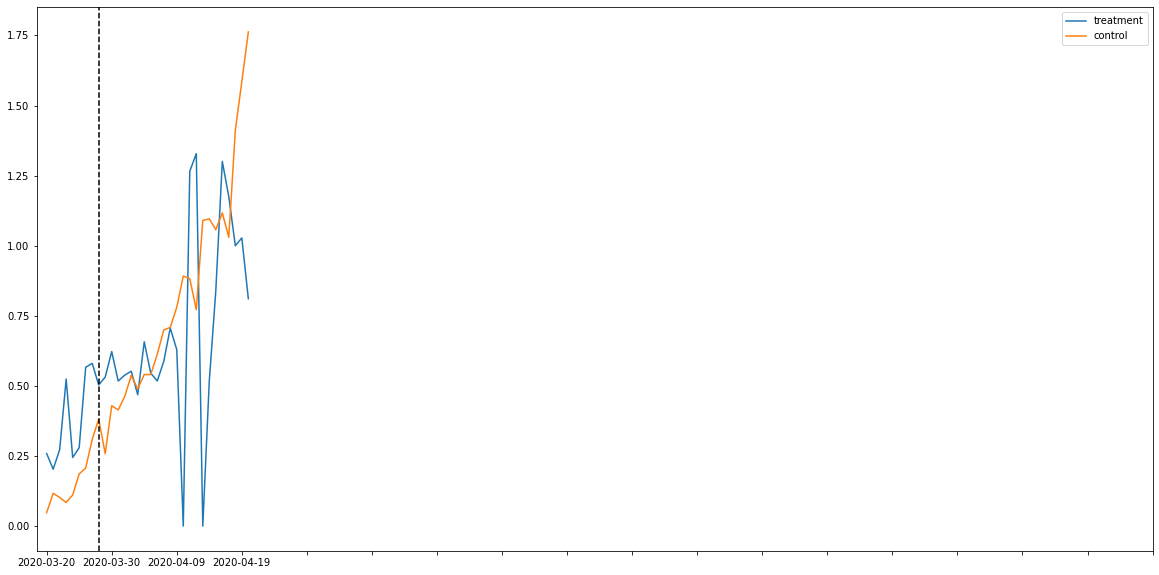

In [66]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(tr_cases_sum.iloc[0,:], label='treatment')
plt.plot(con_cases_sum.iloc[0,:], label='control')
# add x =2020-03-28 black line
plt.axvline(x='2020-03-28', color='black', linestyle='--')
plt.xticks(np.arange(0, 180, 10))
plt.legend()
plt.show()


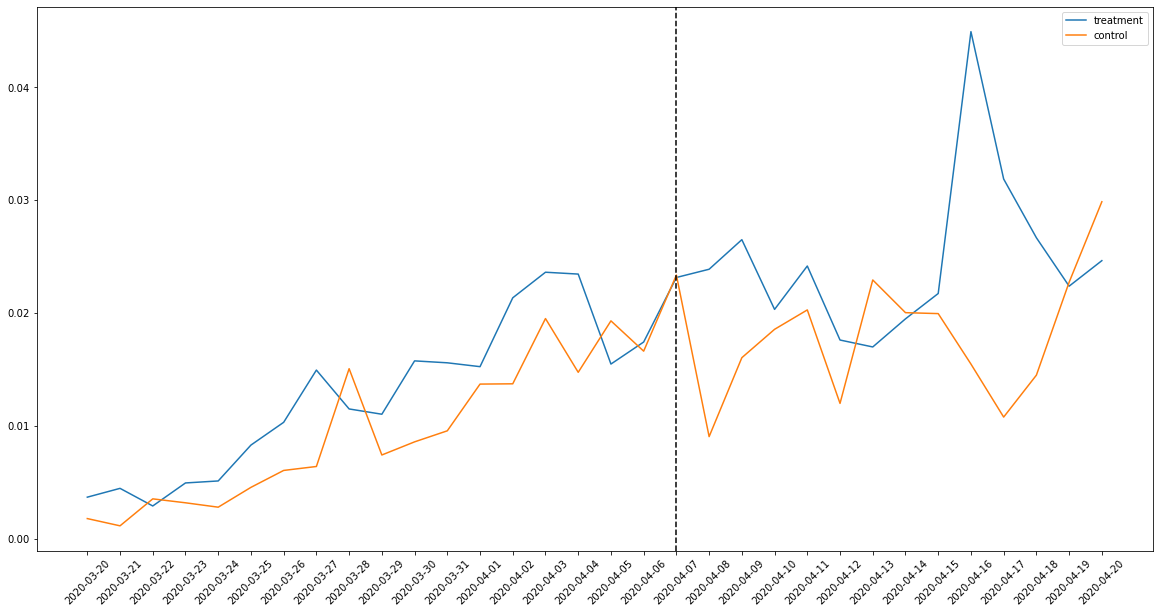

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(tr_cases_sum.iloc[0,:], label='treatment')
plt.plot(con_cases_sum.iloc[0,:], label='control')
# add x =2020-03-28 black line
plt.axvline(x='2020-04-07', color='black', linestyle='--')
# roate the x axis 45 degree
plt.xticks( rotation=45)
plt.legend()
plt.show()


In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [37]:
tr_cases_sum

,2020-03-20,2020-03-21,2020-03-22,2020-03-23,2020-03-24,2020-03-25,2020-03-26,2020-03-27,2020-03-28,2020-03-29,...,2020-04-11,2020-04-12,2020-04-13,2020-04-14,2020-04-15,2020-04-16,2020-04-17,2020-04-18,2020-04-19,2020-04-20
0,0.617162,0.537954,0.706271,0.848185,1.235974,1.620462,1.857261,2.174917,2.262376,2.469472,...,4.2467,3.437294,3.39604,3.590759,3.390264,4.790429,5.00165,4.169142,3.555281,3.590759


In [67]:
# Assuming tr_cases_sum and con_cases_sum are pandas DataFrames
# Make sure your date index is a column named 'ds' and the data is in a column named 'y'
tr_cases_sum = tr_cases_sum.T.reset_index().rename(columns={'index': 'ds', 0: 'y'})
con_cases_sum = con_cases_sum.T.reset_index().rename(columns={'index': 'ds', 0: 'y'})

# Convert the 'ds' column to datetime format
tr_cases_sum['ds'] = pd.to_datetime(tr_cases_sum['ds'])
con_cases_sum['ds'] = pd.to_datetime(con_cases_sum['ds'])

# Separate the data before the inference point
inference_date = '2020-04-07'
tr_cases_before_inference = tr_cases_sum[tr_cases_sum['ds'] < inference_date]
con_cases_before_inference = con_cases_sum[con_cases_sum['ds'] < inference_date]

In [43]:
tr_cases_before_inference

,ds,y
0,2020-03-20,0.617162
1,2020-03-21,0.537954
2,2020-03-22,0.706271
3,2020-03-23,0.848185
4,2020-03-24,1.235974
5,2020-03-25,1.620462
6,2020-03-26,1.857261
7,2020-03-27,2.174917
8,2020-03-28,2.262376
9,2020-03-29,2.469472


In [68]:
# Create and fit the SARIMAX models
# You may need to adjust the order and seasonal_order parameters depending on your data
tr_model = SARIMAX(tr_cases_before_inference['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit()
con_model = SARIMAX(con_cases_before_inference['y'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 7)).fit()

# Make predictions for the entire range of data
tr_forecast = tr_model.get_prediction(start=0, end=len(tr_cases_sum)-1)
con_forecast = con_model.get_prediction(start=0, end=len(con_cases_sum)-1)

# Get confidence intervals
tr_ci = tr_forecast.conf_int(alpha=0.05)
con_ci = con_forecast.conf_int(alpha=0.05)


/Users/dp/opt/miniconda3/envs/dpp/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.
/Users/dp/opt/miniconda3/envs/dpp/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.51962D-01    |proj g|=  9.77381D-01

At iterate    5    f= -2.88393D-01    |proj g|=  4.53161D-02

At iterate   10    f= -2.88748D-01    |proj g|=  4.34155D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     26      1     0     0   1.949D-04  -2.888D-01
  F = -0.28877858829587238     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

/Users/dp/opt/miniconda3/envs/dpp/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


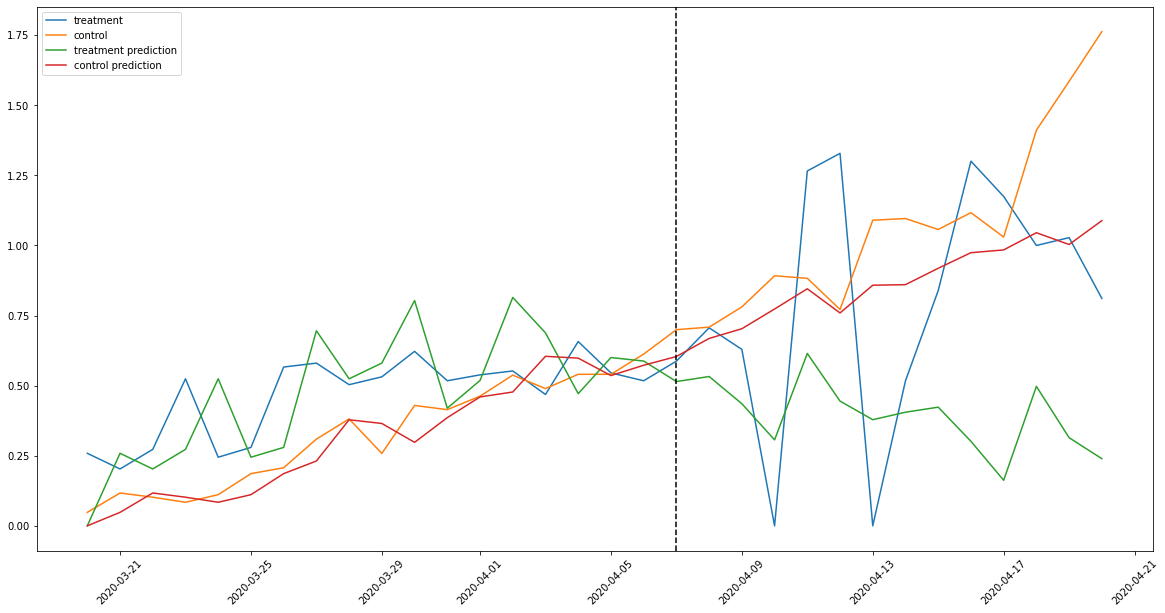

In [69]:
plt.figure(figsize=(20, 10))

plt.plot(tr_cases_sum['ds'], tr_cases_sum['y'], label='treatment')
plt.plot(con_cases_sum['ds'], con_cases_sum['y'], label='control')

plt.plot(tr_cases_sum['ds'], tr_forecast.predicted_mean, label='treatment prediction')
plt.plot(con_cases_sum['ds'], con_forecast.predicted_mean, label='control prediction')

# # Plot the confidence intervals
# plt.fill_between(tr_cases_sum['ds'], tr_ci.iloc[:, 0], tr_ci.iloc[:, 1], alpha=0.2, label='treatment CI')
# plt.fill_between(con_cases_sum['ds'], con_ci.iloc[:, 0], con_ci.iloc[:, 1], alpha=0.2, label='control CI')
from datetime import datetime

inference_date_dt = datetime.strptime(inference_date, '%Y-%m-%d')
plt.axvline(x=inference_date_dt, color='black', linestyle='--')

plt.xticks(rotation=45)
plt.legend()
plt.show()


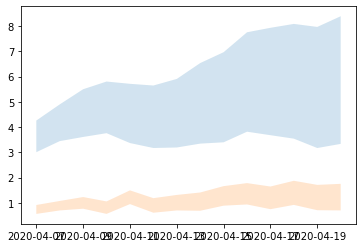

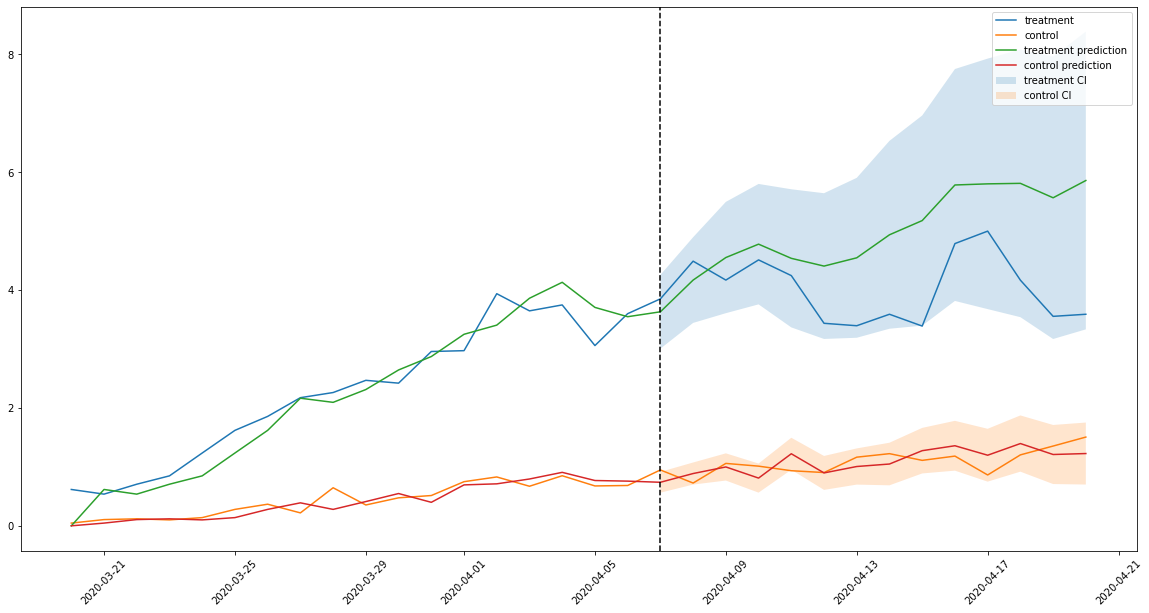

In [51]:
# # Get dates after the inference point
# tr_dates_after_inference = tr_cases_sum[tr_cases_sum['ds'] >= inference_date]['ds']
# con_dates_after_inference = con_cases_sum[con_cases_sum['ds'] >= inference_date]['ds']

# # Get the corresponding confidence intervals
# tr_ci_after_inference = tr_ci.loc[tr_dates_after_inference.index]
# con_ci_after_inference = con_ci.loc[con_dates_after_inference.index]

# # Plot the confidence intervals for the predicted results
# plt.fill_between(tr_dates_after_inference, tr_ci_after_inference.iloc[:, 0], tr_ci_after_inference.iloc[:, 1], alpha=0.2, label='treatment CI')
# plt.fill_between(con_dates_after_inference, con_ci_after_inference.iloc[:, 0], con_ci_after_inference.iloc[:, 1], alpha=0.2, label='control CI')
# plt.figure(figsize=(20, 10))

# plt.plot(tr_cases_sum['ds'], tr_cases_sum['y'], label='treatment')
# plt.plot(con_cases_sum['ds'], con_cases_sum['y'], label='control')

# plt.plot(tr_cases_sum['ds'], tr_forecast.predicted_mean, label='treatment prediction')
# plt.plot(con_cases_sum['ds'], con_forecast.predicted_mean, label='control prediction')

# # Get dates after the inference point
# tr_dates_after_inference = tr_cases_sum[tr_cases_sum['ds'] >= inference_date]['ds']
# con_dates_after_inference = con_cases_sum[con_cases_sum['ds'] >= inference_date]['ds']

# # Get the corresponding confidence intervals
# tr_ci_after_inference = tr_ci.loc[tr_dates_after_inference.index]
# con_ci_after_inference = con_ci.loc[con_dates_after_inference.index]

# # Plot the confidence intervals for the predicted results
# plt.fill_between(tr_dates_after_inference, tr_ci_after_inference.iloc[:, 0], tr_ci_after_inference.iloc[:, 1], alpha=0.2, label='treatment CI')
# plt.fill_between(con_dates_after_inference, con_ci_after_inference.iloc[:, 0], con_ci_after_inference.iloc[:, 1], alpha=0.2, label='control CI')

# inference_date_dt = datetime.strptime(inference_date, '%Y-%m-%d')
# plt.axvline(x=inference_date_dt, color='black', linestyle='--')

# plt.xticks(rotation=45)
# plt.legend()
# plt.show()


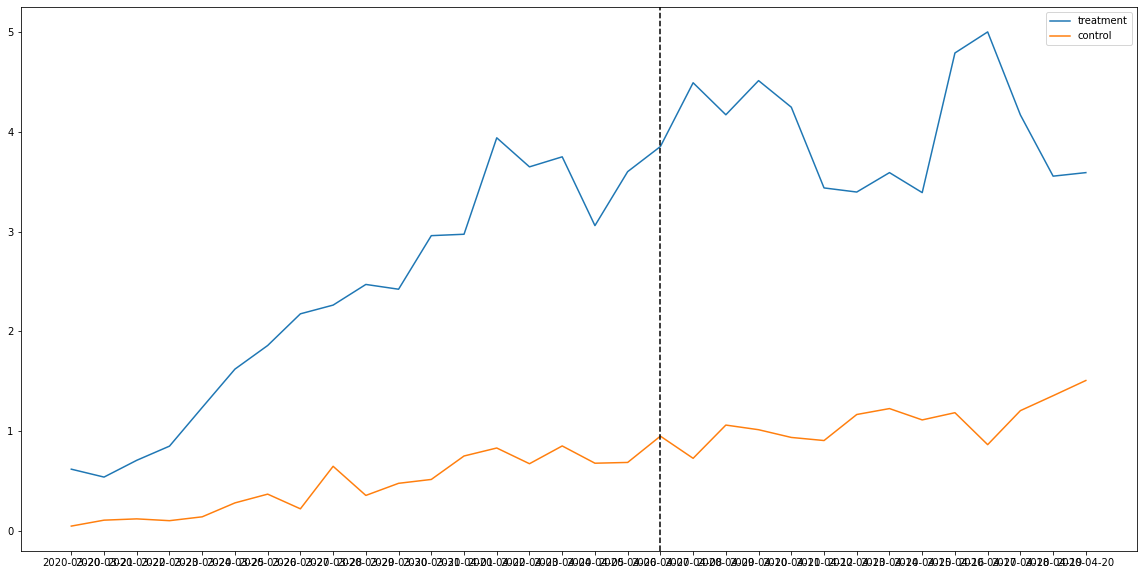

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(tr_cases_sum.iloc[0,:], label='treatment')
plt.plot(con_cases_sum.iloc[0,:], label='control')
# add x =2020-03-28 black line
plt.axvline(x='2020-04-07', color='black', linestyle='--')

plt.legend()
plt.show()

In [68]:
tr=pd.DataFrame(tr_cases_sum).T
# set  the index as the date
tr.index=pd.to_datetime(tr_cases_sum.columns)
tr.columns=['cases/pop_density']
tr

ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import linregress

# Assuming you have data frames df_treatment and df_control with columns "03-20" to "04-20" representing new cases values

# Extract new cases values for x=03-28 from both data frames
x_date = "03-28"
new_cases_treatment = df_treatment[x_date]
new_cases_control = df_control[x_date]

# Plot scatter plot
plt.scatter(new_cases_treatment, new_cases_control)
plt.xlabel("New Cases (Treatment)")
plt.ylabel("New Cases (Control)")
plt.title(f"Scatter Plot of New Cases on {x_date}")
plt.show()

# Fit regression model
slope, intercept, r_value, p_value, std_err = linregress(new_cases_treatment, new_cases_control)

# Calculate predicted new cases values based on the regression model
x = np.linspace(min(new_cases_treatment), max(new_cases_treatment), 100)
y = slope * x + intercept

# Calculate confidence interval
confidence_interval = 1.96 * std_err  # 95% confidence interval

# Plot regression line with confidence interval
plt.scatter(new_cases_treatment, new_cases_control)
plt.plot(x, y, color='red', label='Regression Line')
plt.fill_between(x, y - confidence_interval, y + confidence_interval, color='gray', alpha=0.5, label='Confidence Interval (95%)')
plt.xlabel("New Cases (Treatment)")
plt.ylabel("New Cases (Control)")
plt.title(f"Regression Model with Confidence Interval on {x_date}")
plt.legend()
plt.show()

# Estimate new cases per day for COVID at x=03-28
x_val = df_treatment[x_date].mean()  # Assuming you have multiple data points for x=03-28, take the mean
y_val = slope * x_val + intercept
confidence_interval_lower = y_val - confidence_interval
confidence_interval_upper = y_val + confidence_interval

print(f"Estimated new cases per day for COVID on {x_date}: {y_val}")
print(f"Confidence Interval (95%): [{confidence_interval_lower}, {confidence_interval_upper}]")


In [15]:
CA_cases= cases_final[cases_final['State'] == 'CA']
FL_cases= cases_final[cases_final['State'] == 'FL']

In [19]:
for row in range(len(CA_cases)):
    CA_cases.iloc[row,8:]= CA_cases.iloc[row,8:]/CA_cases.iloc[row,2]

In [21]:
for row in range(len(FL_cases)):
    FL_cases.iloc[row,8:]= FL_cases.iloc[row,8:]/FL_cases.iloc[row,2]

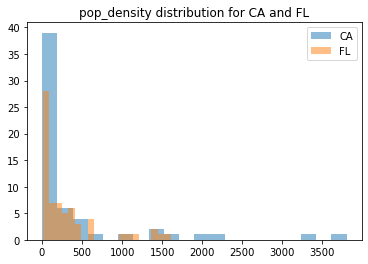

In [5]:
# plot the pop_density distribution for CA and FL
import matplotlib.pyplot as plt
plt.hist(CA_cases['pop_density'], bins= 20, alpha= 0.5, label= 'CA')
plt.hist(FL_cases['pop_density'], bins= 20, alpha= 0.5, label= 'FL')
plt.legend(loc= 'upper right')
plt.title('pop_density distribution for CA and FL')
plt.show()

In [11]:
# drop the outliers <5 and >1600
CA_cases= CA_cases[(CA_cases['pop_density'] > 0) & (CA_cases['pop_density'] < 2000)]
FL_cases= FL_cases[(FL_cases['pop_density'] > 0) & (FL_cases['pop_density'] < 2000)]

In [22]:
CA_cases_sum = CA_cases.iloc[:,8:].sum(axis=0)/len(CA_cases)
FL_cases_sum = FL_cases.iloc[:,8:].sum(axis=0)/len(FL_cases)

In [23]:
CA_cases_sum = pd.DataFrame(CA_cases_sum).T
FL_cases_sum = pd.DataFrame(FL_cases_sum).T

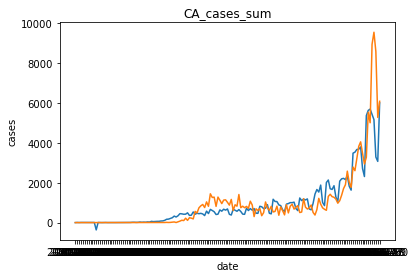

In [21]:
# plot the CA_cases_sum
plt.plot(CA_cases_sum.iloc[0,:])
plt.plot(FL_cases_sum.iloc[0,:])
plt.xlabel('date')
plt.ylabel('cases')
plt.title('CA_cases_sum')
plt.show()

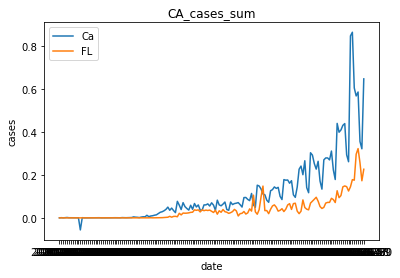

In [25]:
# plot the CA_cases_sum
import matplotlib.pyplot as plt
plt.plot(CA_cases_sum.iloc[0,:])
plt.plot(FL_cases_sum.iloc[0,:])
plt.xlabel('date')
plt.ylabel('cases')
plt.title('CA_cases_sum')
plt.legend(['Ca', 'FL'])
plt.show()

In [30]:
Montana_cases= cases_final[cases_final['State'] == 'MT']
South_Dakota_cases= cases_final[cases_final['State'] == 'SD']

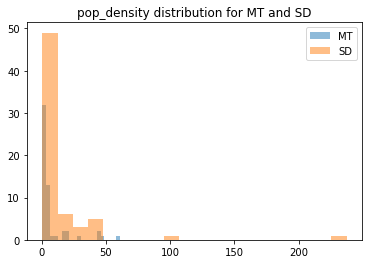

In [31]:
# plot the pop_density distribution for CA and FL
import matplotlib.pyplot as plt
plt.hist(Montana_cases['pop_density'], bins= 20, alpha= 0.5, label= 'MT')
plt.hist(South_Dakota_cases['pop_density'], bins= 20, alpha= 0.5, label= 'SD')
plt.legend(loc= 'upper right')
plt.title('pop_density distribution for MT and SD')
plt.show()

In [6]:
from pandas.tseries.offsets import Day
# df.set_index("date", inplace=True)
df_weekly = df.resample("W", offset=Day(2)).sum().reset_index()

In [7]:
df_weekly["week_num"] = df_weekly["date"].dt.strftime("W%U")
df_wide = df_weekly.pivot_table(index=None, columns="week_num", values="new_cases", aggfunc="sum")

In [8]:
df_wide

week_num,W01
new_cases,260
